# Exploración de datos - Guardados por sede

Este cuaderno analiza el dataset limpio generado por `scripts/clean_profile.py` y resume los patrones necesarios para preparar un modelo de pronóstico por sede y producto.


In [40]:
from __future__ import annotations

from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="talk")
pd.options.display.float_format = lambda x: f"{x:,.2f}"


In [41]:
DATA_PATH = Path("../data/processed/guardados.parquet")

df = pd.read_parquet(DATA_PATH)

df.head()


,fecha,producto,almacenamiento_dia_anterior_tejar,almacenamiento_dia_anterior_cm,almacenamiento_dia_anterior_pa,almacenamiento_dia_anterior_total,peso_sugerido,peso_sugerido_cm,peso_sugerido_pa,peso_sugerido_total,...,total_pa,total,almacenamiento_tejar,almacenamiento_cm,almacenamiento_pa,almacenamiento_total,dia_semana,es_fin_semana,es_quincena,es_pre_quincena
0,2023-01-07,BBQ,"2,000.00","1,333.00","1,451.00","4,784.00","2,100.00","2,100.00","2,100.00","6,300.00",...,"3,400.00","10,200.00","1,990.00","1,328.00","2,195.00","5,513.00",sabado,True,False,False
1,2023-01-07,Carne Molida Mexicana,934.00,481.00,0.00,"1,415.00","1,000.00","1,000.00","1,000.00","3,000.00",...,"1,000.00","2,830.00",658.00,575.00,394.00,"1,627.00",sabado,True,False,False
2,2023-01-07,Cerezas,292.00,257.00,338.00,887.00,500.00,500.00,500.00,"1,500.00",...,500.00,"1,500.00",155.00,196.00,305.00,656.00,sabado,True,False,False
3,2023-01-07,Champiñon Español,972.00,797.00,0.00,"1,769.00","1,800.00","1,800.00","1,800.00","5,400.00",...,"1,800.00","5,400.00","1,530.00",534.00,0.00,"2,064.00",sabado,True,False,False
4,2023-01-07,Chantilly,"1,441.00",567.00,0.00,"2,008.00","3,000.00","3,000.00","3,000.00","9,000.00",...,"3,000.00","8,800.00","1,078.00","1,256.00","1,422.00","3,756.00",sabado,True,False,False


In [42]:
print(f"Filas: {len(df):,}")
print(f"Columnas: {len(df.columns)}")
print("\nRango de fechas:", df['fecha'].min(), "→", df['fecha'].max())
print("Productos únicos:", df['producto'].nunique())
print("Locales presentes en totales:")
for col in ["total_tejar", "total_cm", "total_pa"]:
    print(f"  {col}: valores no nulos = {df[col].notna().sum():,}")


Filas: 12,942
Columnas: 25

Rango de fechas: 2023-01-07 00:00:00 → 2026-09-06 00:00:00
Productos únicos: 41
Locales presentes en totales:
  total_tejar: valores no nulos = 12,942
  total_cm: valores no nulos = 12,942
  total_pa: valores no nulos = 12,942


In [43]:
null_summary = (
    df.isna().mean().mul(100)
    .sort_values(ascending=False)
    .rename("porcentaje_nulos")
)
null_summary.head(10)


almacenamiento_dia_anterior_tejar   0.02
almacenamiento_dia_anterior_cm      0.02
almacenamiento_dia_anterior_total   0.02
fecha                               0.00
total_cm                            0.00
es_quincena                         0.00
es_fin_semana                       0.00
dia_semana                          0.00
almacenamiento_total                0.00
almacenamiento_pa                   0.00
Name: porcentaje_nulos, dtype: float64

In [44]:
sede_cols = {
    "total_tejar": "Tejar",
    "total_cm": "Ciudad Montes",
    "total_pa": "Plaza Américas",
}

series_totales = (
    df.melt(
        id_vars=["fecha", "producto"],
        value_vars=list(sede_cols.keys()),
        var_name="columna",
        value_name="total_kg",
    )
    .dropna(subset=["total_kg"])
    .assign(sede=lambda d: d["columna"].map(sede_cols))
)

series_totales.head()


,fecha,producto,columna,total_kg,sede
0,2023-01-07,BBQ,total_tejar,"3,400.00",Tejar
1,2023-01-07,Carne Molida Mexicana,total_tejar,830.00,Tejar
2,2023-01-07,Cerezas,total_tejar,500.00,Tejar
3,2023-01-07,Champiñon Español,total_tejar,"1,800.00",Tejar
4,2023-01-07,Chantilly,total_tejar,"2,800.00",Tejar


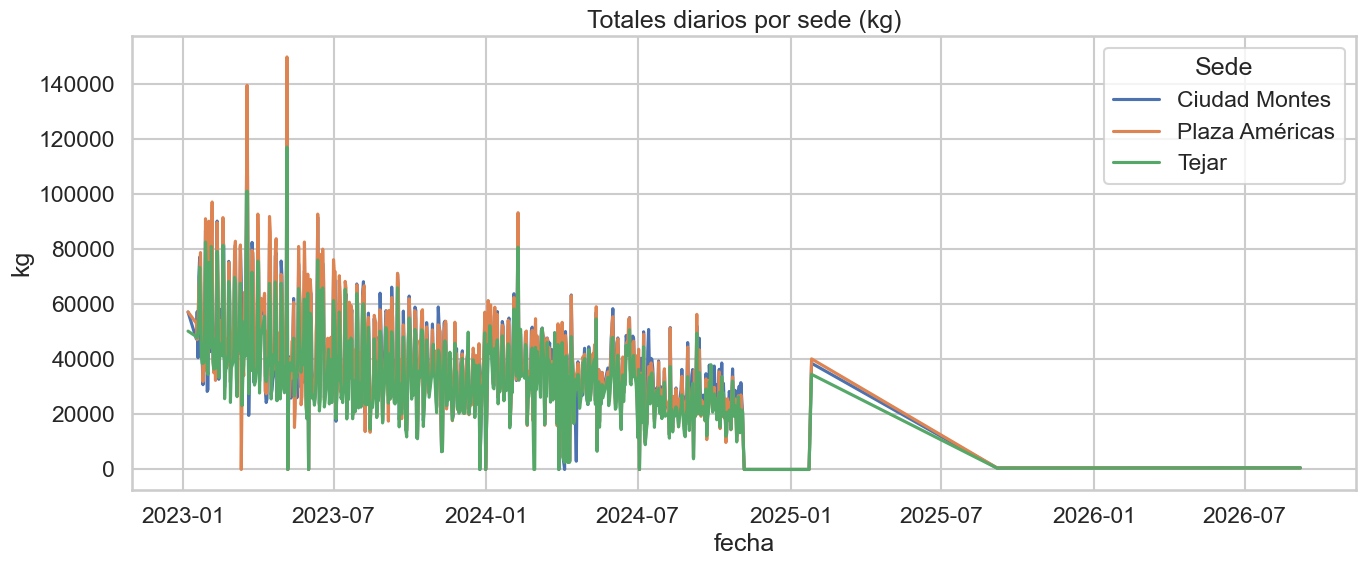

In [45]:
fig, ax = plt.subplots(figsize=(14, 6))
plot_data = (
    series_totales.groupby(["fecha", "sede"])  # total por día y sede
    ["total_kg"].sum()
    .reset_index()
)
sns.lineplot(data=plot_data, x="fecha", y="total_kg", hue="sede", ax=ax)
ax.set_title("Totales diarios por sede (kg)")
ax.set_ylabel("kg")
ax.legend(title="Sede")
plt.tight_layout()


In [46]:
top_productos = (
    df.groupby("producto")[["peso_sugerido", "peso_sugerido_total"]]
    .sum()
    .sort_values("peso_sugerido_total", ascending=False)
    .head(15)
)
top_productos


,peso_sugerido,peso_sugerido_total
producto,,
bananos,"3,181,555.00","11,905,000.00"
pollo,"2,142,760.00","10,015,447.00"
Queso,"2,230,500.00","8,046,720.00"
Ropa Vieja,"1,431,111.00","7,164,979.00"
Mostaneza,"1,824,130.00","5,473,550.00"
masa,"1,191,000.00","4,396,400.00"
salami,"874,520.00","4,280,140.00"
Chantilly,"1,284,360.00","3,927,200.00"
Lechuga,"721,960.00","3,786,861.00"


In [47]:
def build_training_frame(df: pd.DataFrame) -> pd.DataFrame:
    """Genera un dataframe listo para modelar por (fecha, sede, producto)."""
    base = df.copy()

    # columnas base por sede
    value_map = {
        "Tejar": {
            "sugerido": "peso_sugerido",
            "total": "total_tejar",
            "almacen": "almacenamiento_tejar",
        },
        "Ciudad Montes": {
            "sugerido": "peso_sugerido_cm",
            "total": "total_cm",
            "almacen": "almacenamiento_cm",
        },
        "Plaza Américas": {
            "sugerido": "peso_sugerido_pa",
            "total": "total_pa",
            "almacen": "almacenamiento_pa",
        },
    }

    registros = []
    for sede, mapping in value_map.items():
        subset = base[[
            "fecha",
            "producto",
            "peso_sugerido_total",
            "sugerido_produccion_en_cocido",
            "produccion_cocido_real",
            "produccion_cocido_total",
            "almacenamiento_dia_anterior_total",
            "almacenamiento_total",
            "dia_semana",
            "es_fin_semana",
            "es_quincena",
            "es_pre_quincena",
            mapping["sugerido"],
            mapping["total"],
            mapping["almacen"],
        ]].copy()
        subset = subset.rename(
            columns={
                mapping["sugerido"]: "peso_sugerido_sede",
                mapping["total"]: "total_sede",
                mapping["almacen"]: "almacenamiento_sede",
            }
        )
        subset["sede"] = sede
        registros.append(subset)

    return pd.concat(registros, ignore_index=True)

training_df = build_training_frame(df)
training_df.head()


,fecha,producto,peso_sugerido_total,sugerido_produccion_en_cocido,produccion_cocido_real,produccion_cocido_total,almacenamiento_dia_anterior_total,almacenamiento_total,dia_semana,es_fin_semana,es_quincena,es_pre_quincena,peso_sugerido_sede,total_sede,almacenamiento_sede,sede
0,2023-01-07,BBQ,"6,300.00","1,516.00",0.00,"10,200.00","4,784.00","5,513.00",sabado,True,False,False,"2,100.00","3,400.00","1,990.00",Tejar
1,2023-01-07,Carne Molida Mexicana,"3,000.00","1,585.00","1,530.00","2,830.00","1,415.00","1,627.00",sabado,True,False,False,"1,000.00",830.00,658.00,Tejar
2,2023-01-07,Cerezas,"1,500.00",613.00,0.00,"1,500.00",887.00,656.00,sabado,True,False,False,500.00,500.00,155.00,Tejar
3,2023-01-07,Champiñon Español,"5,400.00","3,631.00","3,900.00","5,400.00","1,769.00","2,064.00",sabado,True,False,False,"1,800.00","1,800.00","1,530.00",Tejar
4,2023-01-07,Chantilly,"9,000.00","6,992.00","8,800.00","8,800.00","2,008.00","3,756.00",sabado,True,False,False,"3,000.00","2,800.00","1,078.00",Tejar


In [48]:
def add_rolling_features(data: pd.DataFrame, windows: tuple[int, ...] = (3, 7, 14)) -> pd.DataFrame:
    enriched = data.sort_values(["producto", "sede", "fecha"]).copy()
    for window in windows:
        enriched[f"sugerido_media_{window}d"] = (
            enriched.groupby(["producto", "sede"])["peso_sugerido_sede"].transform(
                lambda s: s.rolling(window, min_periods=1).mean()
            )
        )
        enriched[f"total_media_{window}d"] = (
            enriched.groupby(["producto", "sede"])["total_sede"].transform(
                lambda s: s.rolling(window, min_periods=1).mean()
            )
        )
    return enriched

training_with_roll = add_rolling_features(training_df)
training_with_roll.head()


,fecha,producto,peso_sugerido_total,sugerido_produccion_en_cocido,produccion_cocido_real,produccion_cocido_total,almacenamiento_dia_anterior_total,almacenamiento_total,dia_semana,es_fin_semana,...,peso_sugerido_sede,total_sede,almacenamiento_sede,sede,sugerido_media_3d,total_media_3d,sugerido_media_7d,total_media_7d,sugerido_media_14d,total_media_14d
14338,2023-03-21,0,"4,800.00","4,800.00","3,000.00","3,000.00",0.00,0.00,martes,False,...,"1,500.00","1,000.00",0.00,Ciudad Montes,"1,500.00","1,000.00","1,500.00","1,000.00","1,500.00","1,000.00"
27280,2023-03-21,0,"4,800.00","4,800.00","3,000.00","3,000.00",0.00,0.00,martes,False,...,"1,800.00","1,000.00",0.00,Plaza Américas,"1,800.00","1,000.00","1,800.00","1,000.00","1,800.00","1,000.00"
1396,2023-03-21,0,"4,800.00","4,800.00","3,000.00","3,000.00",0.00,0.00,martes,False,...,"1,500.00","1,000.00",0.00,Tejar,"1,500.00","1,000.00","1,500.00","1,000.00","1,500.00","1,000.00"
12942,2023-01-07,BBQ,"6,300.00","1,516.00",0.00,"10,200.00","4,784.00","5,513.00",sabado,True,...,"2,100.00","3,400.00","1,328.00",Ciudad Montes,"2,100.00","3,400.00","2,100.00","3,400.00","2,100.00","3,400.00"
12985,2023-01-18,BBQ,"2,960.00",147.00,"1,840.00","3,690.00","2,813.00","1,038.00",miercoles,False,...,740.00,"1,100.00",348.00,Ciudad Montes,"1,420.00","2,250.00","1,420.00","2,250.00","1,420.00","2,250.00"


## Siguiente paso: set de entrenamiento y validación

A continuación podemos separar un conjunto de validación reciente para pruebas iniciales del modelo y preparar una plantilla de entrenamiento por sede.


In [49]:
split_date = training_with_roll["fecha"].quantile(0.8)
train_df = training_with_roll[training_with_roll["fecha"] <= split_date].reset_index(drop=True)
val_df = training_with_roll[training_with_roll["fecha"] > split_date].reset_index(drop=True)

print("Fecha de corte:", split_date.date())
print("Entrenamiento:", train_df.shape)
print("Validación:", val_df.shape)


Fecha de corte: 2024-07-15
Entrenamiento: (31107, 22)
Validación: (7719, 22)


## Próximos pasos sugeridos

- Entrenar un modelo base (p. ej. LightGBM o XGBoost) por sede usando `peso_sugerido_sede` como objetivo.
- Ajustar features adicionales (festivos, quincena, rolling de inventario) y evaluar MAE/MAPE.
- Integrar el modelo en un endpoint (FastAPI) que consuma `training_with_roll` y sirva pronósticos a ReTool.


In [50]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [51]:
# Recalcular columnas de entrada excluyendo campos que no
# están disponibles en inferencia
excluded_features = {target, "fecha", "sugerido_produccion_en_cocido", "produccion_cocido_total"}
feature_cols = [col for col in train_df.columns if col not in excluded_features]
print("Total features:", len(feature_cols))


Total features: 18


In [52]:
target = "peso_sugerido_sede"

cat_cols = ["producto", "sede", "dia_semana"]
for col in cat_cols:
    train_df[col] = train_df[col].astype("category")
    val_df[col] = val_df[col].astype("category")

feature_cols = [
    col for col in train_df.columns
    if col not in {target, "fecha"}  # quitamos target y fecha
]

In [53]:
import lightgbm as lgb

metricas = []
modelos = {}

for sede_actual in train_df["sede"].cat.categories:
    train_sede = train_df[train_df["sede"] == sede_actual]
    val_sede = val_df[val_df["sede"] == sede_actual]

    X_train = train_sede[feature_cols]
    y_train = train_sede[target]
    X_val = val_sede[feature_cols]
    y_val = val_sede[target]

    modelo = LGBMRegressor(
        n_estimators=600,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
    )

    modelo.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        categorical_feature=cat_cols,  # acepta nombres de columnas
        callbacks=[lgb.early_stopping(50, verbose=False)],
    )

    y_pred = modelo.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    mape = mean_absolute_percentage_error(y_val, y_pred)

    metricas.append({
        "sede": sede_actual,
        "MAE": mae,
        "MAPE": mape,
        "muestras_val": len(y_val),
    })
    modelos[sede_actual] = modelo
import joblib
from pathlib import Path

MODEL_DIR = Path("../models")
MODEL_DIR.mkdir(exist_ok=True)

for sede_actual, modelo in modelos.items():
    nombre_archivo = MODEL_DIR / f"modelo_lightgbm_{sede_actual.replace(' ', '_')}.pkl"
    joblib.dump(modelo, nombre_archivo)
    print(f"Modelo guardado para {sede_actual} ▶ {nombre_archivo}")
pd.DataFrame(metricas)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3461
[LightGBM] [Info] Number of data points in the train set: 10369, number of used features: 19
[LightGBM] [Info] Start training from score 2279.957662
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3485
[LightGBM] [Info] Number of data points in the train set: 10369, number of used features: 19
[LightGBM] [Info] Start training from score 2427.515479
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

,sede,MAE,MAPE,muestras_val
0,Ciudad Montes,73.12,0.05,2573
1,Plaza Américas,67.40,0.05,2573
2,Tejar,62.42,0.05,2573


In [56]:
import os
from pathlib import Path

MODEL_DIR = Path("../models")
MODEL_DIR.mkdir(exist_ok=True)
print("Carpeta lista:", MODEL_DIR.resolve())

Carpeta lista: /Users/userbia/prediccionMC/models


In [55]:
import joblib